In [2]:
import os
import pandas as pd
import numpy as ny
import tensorflow as tf

In [3]:
df=pd.read_csv(os.path.join('DatasetForCommentsReading','kaggle_parsed_dataset.csv'))

In [4]:
df

,index,oh_label,Date,Text
0,0,1,20120618192155Z,"""You fuck your dad."""
1,1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,3,0,NaN,"""listen if you dont wanna get married to a man..."
4,4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."
...,...,...,...,...
8794,8794,0,20120612003508Z,"""Never really gave it much thought. I just fig..."
8795,8795,0,20120619210456Z,"""Nadie se salva de la regla 34 xd"""
8796,8796,0,20120528234613Z,"""Question: Are you a boy or a girl?"""
8797,8797,1,20120619153537Z,"""Leave your email or phone number and maybe yo..."


In [5]:
#pre processing

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
x=df['Text']
y=df['oh_label'].values

In [12]:
vectorizer=TextVectorization(max_tokens=200000,output_sequence_length=1800,output_mode='int')
vectorizer.adapt(x.values)
vectorized_text=vectorizer(x.values)
vectorized_text

<tf.Tensor: shape=(8799, 1800), dtype=int64, numpy=
array([[    3,    63,    12, ...,     0,     0,     0],
       [   10,    84,    28, ...,     0,     0,     0],
       [29005,     7,  4215, ...,     0,     0,     0],
       ...,
       [  473,     8,     3, ...,     0,     0,     0],
       [  581,    12,  1216, ...,     0,     0,     0],
       [   46,     2, 15574, ...,     0,     0,     0]], dtype=int64)>

In [14]:
dataset=tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset=dataset.cache()
dataset=dataset.shuffle(9000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)

In [19]:
train=dataset.take(int(len(dataset)*.7))
val=dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
### CREATING MODEL

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [24]:
model=Sequential()
model.add(Embedding(200001,32))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [25]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                        

In [ ]:
training=model.fit(train,epochs=20,validation_data=val)

Epoch 1/20
 61/385 [===>..........................] - ETA: 4:25 - loss: 0.3570

In [28]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

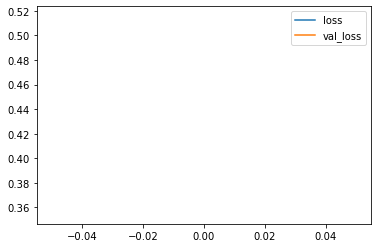

In [31]:
plt.figure(figsize=(8,5))
pd.DataFrame(training.history).plot()
plt.show()

In [32]:
### PREDICTION

In [48]:
#test_input=vectorizer('you love!')
batch=test.as_numpy_iterator().next()
batch_x, batch_y =test.as_numpy_iterator().next()
(model.predict(batch_x)>0.5).astype(int)

1/1 [==============================] - 0s 120ms/step


array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [49]:
batch_y

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int64)